# Predicting fraudulent Ethereum transactions

In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings

In [294]:
#Importing Dataset
df = pd.read_csv("transaction_dataset.csv", index_col=0)

In [295]:
# print(*sorted(df.columns.tolist()), sep='\n')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9841 entries, 0 to 9840
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Index                                                 9841 non-null   int64  
 1   Address                                               9841 non-null   object 
 2   FLAG                                                  9841 non-null   int64  
 3   Avg min between sent tnx                              9841 non-null   float64
 4   Avg min between received tnx                          9841 non-null   float64
 5   Time Diff between first and last (Mins)               9841 non-null   float64
 6   Sent tnx                                              9841 non-null   int64  
 7   Received Tnx                                          9841 non-null   int64  
 8   Number of Created Contracts                           9841

In [296]:
# Omit first two columns (Index, Address)
df = df.iloc[:,2:]
df.shape

(9841, 48)

# Por ahora las tiro a mano
Pero falta justificar

Me gustaría separar las categóricas en un df aparte, y tratarlas como se debe: con un encoding que no genere tantas variables, o usando PCA después de encodear.

Otra cosa que me interesa es si puedo justificar tirarlas antes de encodear, o values insignificantes después de encodear.

Aparentemente las categóricas las puedo incluir en selectKbest

El tema es que para eso, el tema de tirar las que tienen poca varianza lo tengo que hacer con un subset de df, pero tirarlas en df

In [297]:
# Drop the two categorical features
# para qué está el "astype('category')"?
categories = df.select_dtypes('O').columns.astype('category')
df.drop(df[categories], axis=1, inplace=True)
df.shape

(9841, 46)

In [298]:
# Inspect features variance
# ahora son todas numéricas
# numericals = df.select_dtypes(include=['float','int']).columns
# df[numericals].var()
df.var()

FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062298e+05
max value received                                      1.692294e+08
avg val received                                        8.323238e+06
min val sent                                            1.921264e+04
max val sent                                            4.394646e+07
avg val sent                      

Esta no la sabía:

### Ojo:

Variance is range-dependent, therefore we need to do normalization before applying this technique.

Sin embargo, ninguna transformación va a cambiar el hecho de que una varianza sea 0, así que si lo que quiero hacer es tirar las que tienen varianza nula (no muy chica) entonces no va a haber problema

In [299]:
# Filtering the features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print(df.var())
print(df.shape)

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64


FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                    

0    7662
1    2179
Name: FLAG, dtype: int64


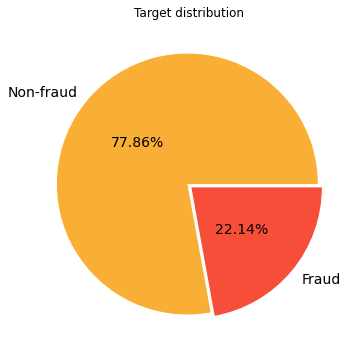

In [300]:
# Inspect target distribution
print(df['FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[6,6])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

Esto está bueno:

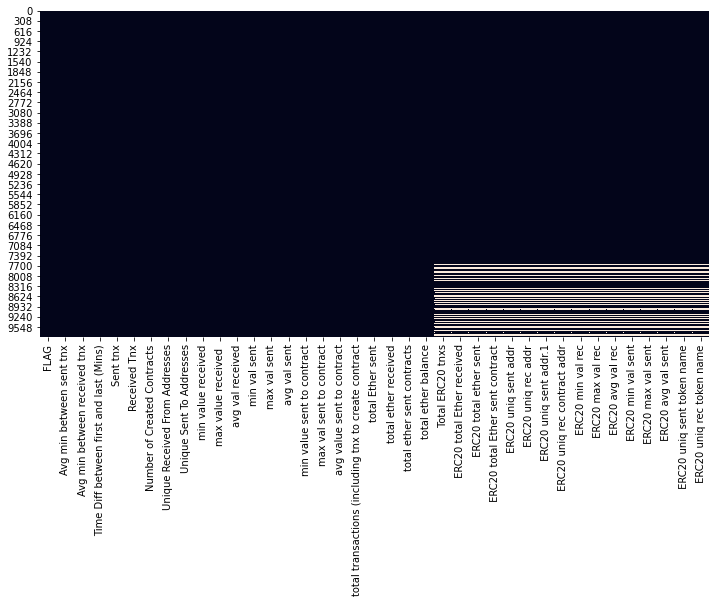

In [301]:
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

Imputo missings con la mediana:

In [302]:
# Replace missings of numerical variables with median
df.fillna(df.median(), inplace=True)

# Esto no lo uso para nada

Lo elimino?

Originalmente Kendall se usa cuando hay variables binarias, que en este caso creo que no hay. Está mal usarlo en otro caso?

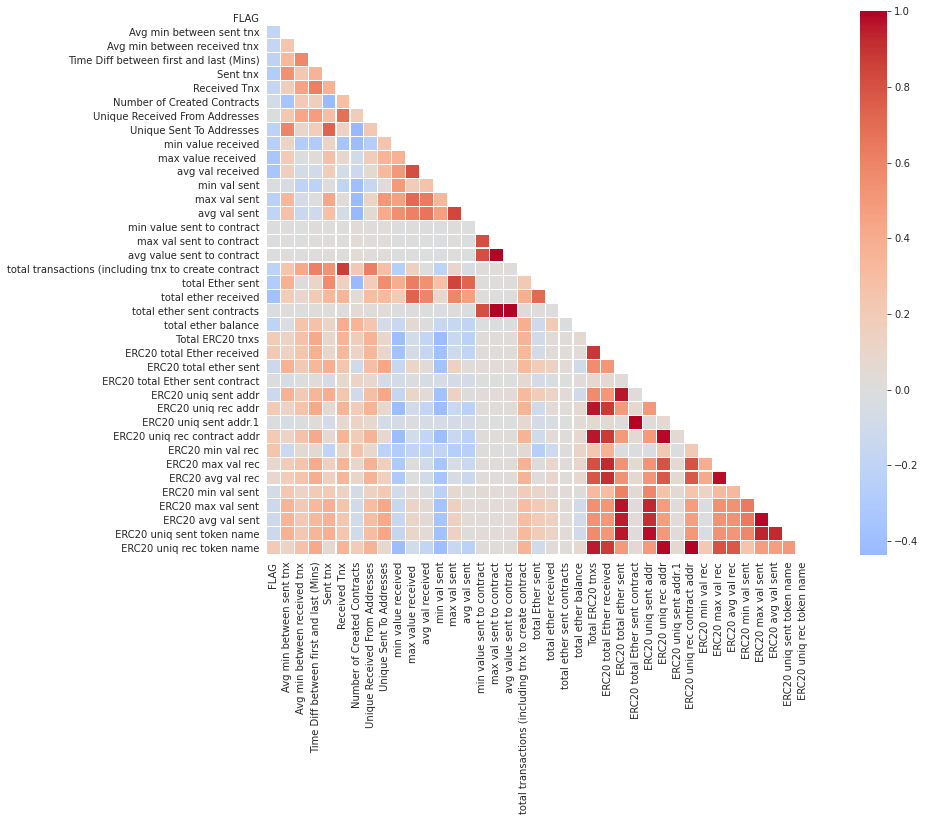

In [303]:
# calculate correlation matrix
corr = df.corr(method = 'kendall')

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, center=0, cmap='coolwarm', linewidths=0.1, square=True)

In [304]:
# Some features present a small distribution
drops = []
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 10:
        drops.append(i)
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

The column min value sent to contract has the following distribution: 
0.00    9839
0.02       1
0.01       1
Name: min value sent to contract, dtype: int64
The column max val sent to contract has the following distribution: 
0.000000    9838
0.020000       1
0.010000       1
0.046029       1
Name: max val sent to contract, dtype: int64
The column avg value sent to contract has the following distribution: 
0.000000    9838
0.023014       1
0.020000       1
0.010000       1
Name: avg value sent to contract, dtype: int64
The column total ether sent contracts has the following distribution: 
0.000000    9838
0.020000       1
0.046029       1
0.010000       1
Name: total ether sent contracts, dtype: int64
The column  ERC20 uniq sent addr.1 has the following distribution: 
0.0    9813
1.0      26
2.0       1
3.0       1
Name:  ERC20 uniq sent addr.1, dtype: int64


In [305]:
print(drops)
df.drop(drops, axis=1, inplace=True)
print(df.shape)

['min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total ether sent contracts', ' ERC20 uniq sent addr.1']
(9841, 34)


It can be observed that the values of these two variables are mosty 0s. Thus, both features will be discarded since they will not be helpful for our model

In [306]:
# separo en X e y:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape, y.shape)

(9841, 33) (9841,)


# Feature selection

In [307]:
# pruebo un método de feature selection
# quedarme con los k mejores
# requiere tener definidos X, y

from sklearn.feature_selection import SelectKBest, chi2, f_classif

k=14
X_selected = SelectKBest(f_classif, k=k).fit_transform(X, y)
model= SelectKBest(f_classif, k=k).fit(X,y)

Selected_feature_names=X.columns[model.get_support()]
X = X[Selected_feature_names]

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9841 entries, 0 to 9840
Data columns (total 14 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Avg min between sent tnx                              9841 non-null   float64
 1   Avg min between received tnx                          9841 non-null   float64
 2   Time Diff between first and last (Mins)               9841 non-null   float64
 3   Sent tnx                                              9841 non-null   int64  
 4   Received Tnx                                          9841 non-null   int64  
 5   Unique Received From Addresses                        9841 non-null   int64  
 6   Unique Sent To Addresses                              9841 non-null   int64  
 7   avg val sent                                          9841 non-null   float64
 8   total transactions (including tnx to create contract  9841

In [308]:
# Split into training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7872, 14) (7872,)
(1969, 14) (1969,)


### Tenerlo en cuenta para discutir:

Standardization is beneficial in many cases. It improves the numerical stability of the model and often reduces training time. However, standardization isn’t always great. It can harm the performance of distance-based clustering algorithms by assuming equal importance of features. If there are inherent importance differences between features, it’s generally not a good idea to do standardization

In [309]:
# Normalize the training features
norm = PowerTransformer()
norm_train_f = norm.fit_transform(X_train)

In [310]:
norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)
norm_df.head()

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Unique Received From Addresses,Unique Sent To Addresses,avg val sent,total transactions (including tnx to create contract,Total ERC20 tnxs,ERC20 uniq rec addr,ERC20 uniq rec contract addr,ERC20 uniq sent token name,ERC20 uniq rec token name
0,1.294061,1.151313,1.393751,1.591951,1.017881,1.268692,1.873167,0.651223,1.222096,1.907801,1.783833,1.829828,2.379702,1.831406
1,-1.096066,-1.184221,-1.638410,-1.391726,-1.785005,-2.250405,-1.490712,-1.138468,-2.084269,0.129207,0.228526,0.224883,-0.437345,0.226082
2,-0.006354,0.213137,1.103220,1.970707,1.876994,0.164531,-0.343138,-0.869934,1.951690,-0.980368,-0.995095,-0.993733,-0.437345,-0.994019
3,-1.096066,1.220438,0.195684,-1.391726,-0.618856,-0.213813,-1.490712,-1.138468,-0.786382,-0.980368,-0.995095,-0.993733,-0.437345,-0.994019
4,0.628503,-1.121221,-0.904665,-0.206187,-0.618856,-0.213813,0.168964,1.332663,-0.612613,-0.980368,-0.995095,-0.993733,-0.437345,-0.994019


# Balancing the dataset
### Oversampling using SMOTE:

In [311]:
oversample = SMOTE()
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((7872, 14), (7872,))
Shape of the training after SMOTE: ((12230, 14), (12230,))


# Logistic Regression

In [312]:
LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)

# Transform test features
norm_test_f = norm.transform(X_test)
preds = LR.predict(norm_test_f)

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1547
           1       0.73      0.93      0.82       422

    accuracy                           0.91      1969
   macro avg       0.85      0.92      0.88      1969
weighted avg       0.92      0.91      0.91      1969



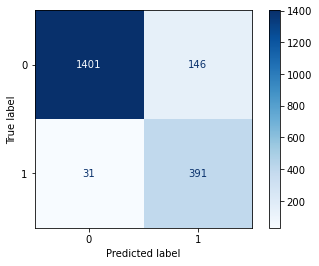

In [313]:
# print(classification_report(y_test, preds))
# print(confusion_matrix(y_test, preds))
# _ = plot_confusion_matrix(LR, norm_test_f, y_test)

# usando scaling en lugar de normalization

print(classification_report(y_test, preds))
report = classification_report(y_test, preds, output_dict=True)

# print(confusion_matrix(y_test, preds))
_ = plot_confusion_matrix(LR, norm_test_f, y_test, cmap="Blues")

acc = report['accuracy']
prec = report['1']['precision']
rec = report['1']['recall']
f1 = report['1']['f1-score']

results = pd.DataFrame([['Logistic Regression', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Random Forest Classifier
Leer cómo funciona

Cómo elige el random state?

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1547
           1       0.92      0.95      0.94       422

    accuracy                           0.97      1969
   macro avg       0.95      0.97      0.96      1969
weighted avg       0.97      0.97      0.97      1969



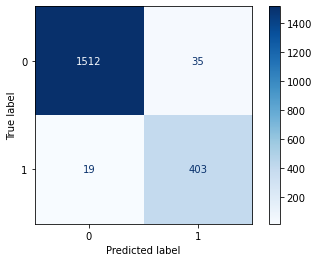

In [314]:
RF = RandomForestClassifier(random_state=42)
RF.fit(x_tr_resample, y_tr_resample)
preds_RF = RF.predict(norm_test_f)

print(classification_report(y_test, preds_RF))
# print(confusion_matrix(y_test, preds_RF))
_ = plot_confusion_matrix(RF, norm_test_f, y_test, cmap="Blues")

report = classification_report(y_test, preds_RF, output_dict=True)

acc = report['accuracy']
prec = report['1']['precision']
rec = report['1']['recall']
f1 = report['1']['f1-score']

model_results = pd.DataFrame([['Random Forest Classifier', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)

# XGB Classifier
Leer cómo funciona

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1547
           1       0.93      0.97      0.95       422

    accuracy                           0.98      1969
   macro avg       0.96      0.97      0.97      1969
weighted avg       0.98      0.98      0.98      1969



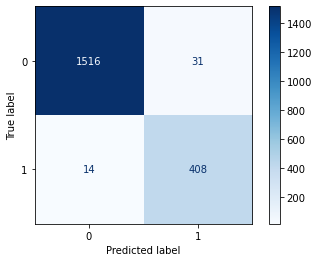

In [315]:
warnings.filterwarnings(action='ignore', category=UserWarning)

xgb_c = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_c.fit(x_tr_resample, y_tr_resample)
preds_xgb = xgb_c.predict(norm_test_f)

print(classification_report(y_test, preds_xgb))
# print(confusion_matrix(y_test, preds_xgb))
_ = plot_confusion_matrix(xgb_c, norm_test_f, y_test, cmap="Blues")

report = classification_report(y_test, preds_xgb, output_dict=True)

acc = report['accuracy']
prec = report['1']['precision']
rec = report['1']['recall']
f1 = report['1']['f1-score']

model_results = pd.DataFrame([['XGB Classifier', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)

# ROC curve
Cómo se interpreta?

In [316]:
# Plotting AUC for untuned XGB Classifier
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

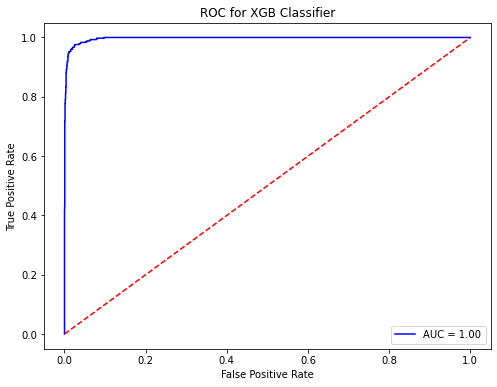

In [317]:
plt.figure(figsize=(8,6))
plt.title('ROC for XGB Classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# K-Nearest Neighbors (KNN)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1547
           1       0.87      0.97      0.92       422

    accuracy                           0.96      1969
   macro avg       0.93      0.97      0.95      1969
weighted avg       0.97      0.96      0.96      1969



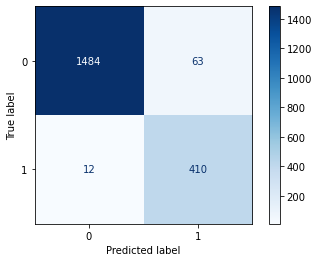

In [318]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=15, metric='minkowski', p= 2)
classifier.fit(x_tr_resample, y_tr_resample)

preds = classifier.predict(norm_test_f)

print(classification_report(y_test, preds))
# print(confusion_matrix(y_test, preds_xgb))
_ = plot_confusion_matrix(classifier, norm_test_f, y_test, cmap="Blues")

report = classification_report(y_test, preds, output_dict=True)

acc = report['accuracy']
prec = report['1']['precision']
rec = report['1']['recall']
f1 = report['1']['f1-score']

model_results = pd.DataFrame([['KNN', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)

# Naive Bayes

              precision    recall  f1-score   support

           0       0.96      0.85      0.91      1547
           1       0.62      0.89      0.73       422

    accuracy                           0.86      1969
   macro avg       0.79      0.87      0.82      1969
weighted avg       0.89      0.86      0.87      1969



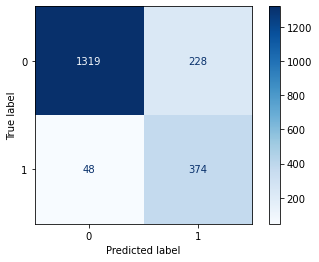

In [319]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_tr_resample, y_tr_resample)

preds = classifier.predict(norm_test_f)

print(classification_report(y_test, preds))
# print(confusion_matrix(y_test, preds_xgb))
_ = plot_confusion_matrix(classifier, norm_test_f, y_test, cmap="Blues")

report = classification_report(y_test, preds, output_dict=True)

acc = report['accuracy']
prec = report['1']['precision']
rec = report['1']['recall']
f1 = report['1']['f1-score']

model_results = pd.DataFrame([['Naive Bayes', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)

# Decision Tree

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1547
           1       0.89      0.93      0.91       422

    accuracy                           0.96      1969
   macro avg       0.94      0.95      0.94      1969
weighted avg       0.96      0.96      0.96      1969



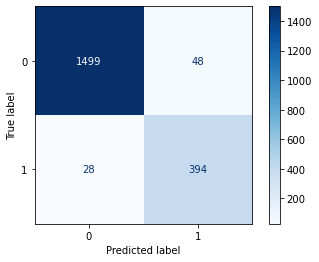

In [320]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier.fit(x_tr_resample, y_tr_resample)

preds = classifier.predict(norm_test_f)

print(classification_report(y_test, preds))
# print(confusion_matrix(y_test, preds_xgb))
_ = plot_confusion_matrix(classifier, norm_test_f, y_test, cmap="Blues")

report = classification_report(y_test, preds, output_dict=True)

acc = report['accuracy']
prec = report['1']['precision']
rec = report['1']['recall']
f1 = report['1']['f1-score']

model_results = pd.DataFrame([['Decision Tree', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)

# Model comparison
Because we don't want to miss any fraudulent transaction, we want Recall to be as high as possible.

In [321]:
results.sort_values(by=['Recall'], ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
3,KNN,0.961910,0.866808,0.971564,0.916201
2,XGB Classifier,0.977146,0.929385,0.966825,0.947735
1,Random Forest Classifier,0.972575,0.920091,0.954976,0.937209
5,Decision Tree,0.961402,0.891403,0.933649,0.912037
0,Logistic Regression,0.910107,0.728119,0.926540,0.815433
4,Naive Bayes,0.859827,0.621262,0.886256,0.730469


Tener en cuenta que los 2 primeros dan tan parecido que a veces se intercambian el puesto.

Todos estos algoritmos tienen algo random?